In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

In [19]:
class PointLensModel:
    def __init__(self, f0, t0, td, y):
        """
        f0 is the base flux
        t0 is the time at which the lensing event happens
        y is the min distance expressed in units of einstein radius 
        td is the duration of the event
        """
        self.f0 = f0
        self.t0 = t0
        self.td = td
        self.y = y
        

    def compute_angles_fn(ts, t0, td, y):
        return np.sqrt(((ts-t0)/td)**2 + y**2)
                       
    def compute_magnification_fn(angle_ratios):
        return (angle_ratios**2 + 2)/(angle_ratios*np.sqrt(angle_ratios**2 + 4))

    def compute_fluxes_fn(ts, f0, t0, td, y):
        angles = PointLensModel.compute_angles_fn(ts, t0, td, y)
        fluxes = PointLensModel.compute_magnification_fn(angles)*f0
        return fluxes
    
    def compute_L2_fn(pfluxes, fluxes):
        return np.mean((pfluxes - fluxes)**2)
    
    def compute_weighted_L2_fn(pfluxes, fluxes, errors):
        return np.mean(((pfluxes - fluxes)/errors)**2)
    
    def model_L2(params, *args):
        f0 = params[0]
        t0 = params[1]
        td = params[2]
        y = params[3]
        ts = args[0]
        fluxes = args[1]
        return PointLensModel.compute_L2_fn(PointLensModel.compute_fluxes_fn(ts, f0, t0, td, y), fluxes)
    
    def model_weighted_L2(params, *args):
        f0 = params[0]
        t0 = params[1]
        td = params[2]
        y = params[3]
        ts = args[0]
        fluxes = args[1]
        errors = args[2]
        return PointLensModel.compute_weighted_L2_fn(PointLensModel.compute_fluxes_fn(ts, f0, t0, td, y), fluxes, errors)
        
    def compute_fluxes(self, ts):
        return PointLensModel.compute_fluxes_fn(ts, self.f0, self.t0, self.td, self.y)
    
    def guess_f0(ts, fluxes):
        return np.min(fluxes)
    
    def guess_t0(ts, fluxes):
        i = np.argmax(fluxes)
        return ts[i]
    
    def guess_td(ts, fluxes):
        f1 = np.max(fluxes)
        f0 = np.min(fluxes)
        fmid = (f1+f0)/2
        valid_t = ts[fluxes>fmid]
        return np.std(valid_t)
    
    def guess_y(ts, fluxes):
        f1 = np.max(fluxes)
        return 1.2/f1

    def fit(self, ts, fluxes, cost=PointLensModel.model_L2):
        g_f0 = PointLensModel.guess_f0(ts, fluxes)
        g_t0 = PointLensModel.guess_t0(ts, fluxes)
        g_td = PointLensModel.guess_td(ts, fluxes)
        g_y = PointLensModel.guess_y(ts, fluxes)
        ret = minimize(PointLensModel.model_L2, [g_f0, g_t0, g_td, g_y], (ts, fluxes))
        if not ret.success:
            print(ret.message)
            return
        self.f0, self.t0, self.td, self.y = ret.x
        print(ret.x)

    
    def mag2flux(mags):
        return 10**((22.5 - mags)/2.5)
    
    def flux2mag(fluxes):
        return 22.5 - 2.5*np.log10(fluxes)
    
    def plot_range(self, st, et, counts = 1000):
        ts = np.linspace(st, et, counts)
        fluxes = self.compute_fluxes(ts)
        plt.plot(ts, fluxes)
        plt.show()

        
    
        

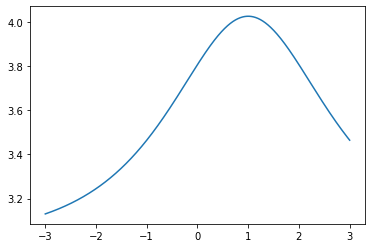

In [20]:
model = PointLensModel(3, 1, 2, 1)
model.plot_range(-3, 3)

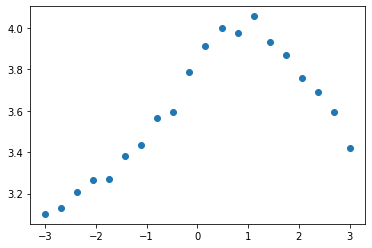

In [21]:
ts = np.linspace(-3, 3, 20)
fluxes = model.compute_fluxes(ts) + (np.random.rand((20))-0.5)/10
plt.scatter(ts, fluxes)
plt.show()

In [22]:
model.fit(ts, fluxes)

[2.95686776 0.95040301 2.13276261 0.97460625]


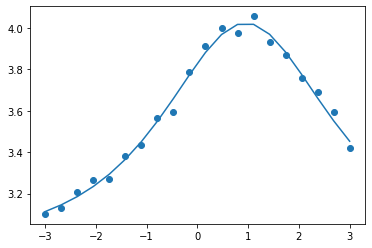

In [23]:
fluxes2 = model.compute_fluxes(ts)
plt.plot(ts, fluxes2)
plt.scatter(ts, fluxes)
plt.show()

[]

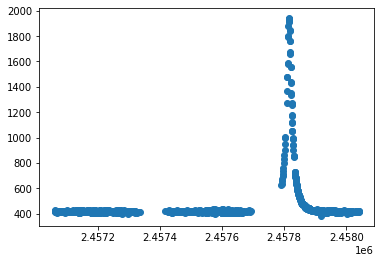

In [24]:
data = np.loadtxt('../data/phot.dat')[:, :2].transpose()
ts = data[0]
fluxes = PointLensModel.mag2flux(data[1])


plt.scatter(ts, fluxes)
plt.plot()


In [25]:
model = PointLensModel(0,0,0,0)

[4.17851146e+02 2.45781572e+06 3.04586488e+01 2.18861495e-01]
383.0010812264479 2457814.83824 4.982566284471079 0.0006182743734981074


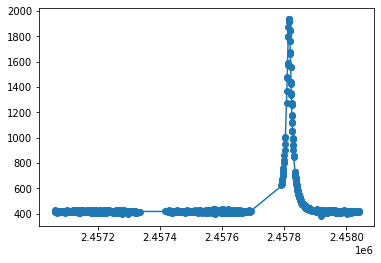

In [26]:
plt.scatter(ts, fluxes)

model.fit(ts, fluxes)
print(PointLensModel.guess_f0(ts, fluxes), PointLensModel.guess_t0(ts, fluxes), PointLensModel.guess_td(ts, fluxes), PointLensModel.guess_y(ts, fluxes))
fluxes2 = model.compute_fluxes(ts)
plt.plot(ts, fluxes2)

plt.show()